In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

from scikeras.wrappers  import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import numpy as np

In [ ]:
from ucimlrepo import fetch_ucirepo

def load_dataset():
  # fetch dataset
  adult = fetch_ucirepo(id=2)

  # data (as pandas dataframes)
  X = adult.data.features
  y = adult.data.targets

  # metadata
  print(adult.metadata)

  # variable information
  variables_info = adult.variables
  print(variables_info)

  return X, y, variables_info

In [ ]:
X_raw, y_raw, var_info = load_dataset()

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [ ]:
import pandas as pd
def print_unique_feature_values(X, var_info=var_info):
  all_features = var_info[var_info.role == 'Feature']
  features = all_features[all_features['type'] =='Categorical']
  # Feature 'sex' is a binary type which is categorical too
  other_categorical = all_features[all_features['type'] == 'Binary']
  features = pd.concat((features, other_categorical), axis=0)
  df = pd.DataFrame(columns=['feature', 'unique_value_count', 'unique_values', 'has \'?\''])
  for i, feature in features.iterrows():
    name = feature['name']
    unique = X[name].unique().T
    df.loc[len(df.index)] = [name, len(unique), unique, '?' in unique.tolist()]
  display(df)
print_unique_feature_values(X_raw)

,feature,unique_value_count,unique_values,has '?'
0,workclass,10,"[State-gov, Self-emp-not-inc, Private, Federal...",True
1,education,16,"[Bachelors, HS-grad, 11th, Masters, 9th, Some-...",False
2,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",False
3,occupation,16,"[Adm-clerical, Exec-managerial, Handlers-clean...",True
4,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",False
5,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",False
6,native-country,43,"[United-States, Cuba, Jamaica, India, ?, Mexic...",True
7,sex,2,"[Male, Female]",False


In [ ]:

print(y_raw.income.unique())


['<=50K' '>50K' '<=50K.' '>50K.']


In [ ]:
def print_unknowns(X):
  all_feature_names = var_info[var_info.role == 'Feature']['name']
  df = pd.DataFrame(columns=['feature', '\'?\'count'])
  for f_name in all_feature_names:
    count = len(X[X[f_name] == '?'].index)
    df.loc[len(df.index)] = [f_name, count]
    #print(f'{f_name} : {count}')
  display(df)
print(X_raw.shape)
print_unknowns(X_raw)

(48842, 14)


,feature,'?'count
0,age,0
1,workclass,1836
2,fnlwgt,0
3,education,0
4,education-num,0
5,marital-status,0
6,occupation,1843
7,relationship,0
8,race,0
9,sex,0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def preprocess(features, labels, var_info):
  # Create copies to avoid changing raw features and labels
  X = features.copy()
  y = labels.copy()

  X.isna().sum()

  # Clean the data - remove missing value rows
  features_missing_values = var_info[var_info['missing_values'] == 'yes']
  rows_to_remove = set()
  for index, row in features_missing_values.iterrows():
    feature_name = row['name']
    rows_to_remove.update(X.index[X[feature_name].isna()].tolist());

  # Clean further - remove data with '?' values in them
  all_feature_names = var_info[var_info.role == 'Feature']['name']
  for feature_name in all_feature_names:
    rows_to_remove.update(X[X[feature_name] == '?'].index)

  X.drop(rows_to_remove, axis = 0, inplace=True)
  y.drop(rows_to_remove, axis = 0, inplace=True)

  # Encode categorical feature values and store encoders to later decode them
  categorical = var_info[var_info['type'] == 'Categorical']
  encoders = pd.DataFrame(columns=['name', 'encoders'])
  for index, row in categorical.iterrows():
    feature_name = row['name']
    le = LabelEncoder()
    X[feature_name] = le.fit_transform(X[feature_name])
    encoders.loc[len(encoders.index)] = [feature_name, le]
  le = LabelEncoder()
  X['sex'] = le.fit_transform(X['sex'])
  encoders.loc[len(encoders.index)] = ['sex', le]
  le = LabelEncoder()
  y['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
  y['income'] = le.fit_transform(y['income'])
  encoders.loc[len(encoders.index)] = ['income', le]

  return X, y, encoders


In [ ]:
X, y, encoders = preprocess(X_raw, y_raw, var_info)

In [ ]:
print(y)

       income
0           0
1           0
2           0
3           0
4           0
...       ...
48836       0
48837       0
48839       0
48840       0
48841       1

[45222 rows x 1 columns]


In [ ]:
X.head()
print_unique_feature_values(X_raw)
print_unique_feature_values(X)

,feature,unique_value_count,unique_values,has '?'
0,workclass,10,"[State-gov, Self-emp-not-inc, Private, Federal...",True
1,education,16,"[Bachelors, HS-grad, 11th, Masters, 9th, Some-...",False
2,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",False
3,occupation,16,"[Adm-clerical, Exec-managerial, Handlers-clean...",True
4,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",False
5,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",False
6,native-country,43,"[United-States, Cuba, Jamaica, India, ?, Mexic...",True
7,sex,2,"[Male, Female]",False


,feature,unique_value_count,unique_values,has '?'
0,workclass,7,"[5, 4, 2, 0, 1, 3, 6]",False
1,education,16,"[9, 11, 1, 12, 6, 15, 7, 5, 10, 8, 14, 4, 0, 1...",False
2,marital-status,7,"[4, 2, 0, 3, 5, 1, 6]",False
3,occupation,14,"[0, 3, 5, 9, 7, 11, 13, 4, 6, 12, 2, 10, 1, 8]",False
4,relationship,6,"[1, 0, 5, 3, 4, 2]",False
5,race,5,"[4, 2, 1, 0, 3]",False
6,native-country,41,"[38, 4, 22, 18, 25, 32, 15, 8, 1, 10, 19, 29, ...",False
7,sex,2,"[1, 0]",False


In [ ]:
y.income.unique()

array([0, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will scale only the numerical features in the dataset and not scale the categorical features in the dataset.
Finally we will convert the dataframe to numpy array.

In [ ]:
numeric_features_train = X_train.select_dtypes(include=['int64', 'float64'])
numeric_features_test = X_test.select_dtypes(include=['int64', 'float64'])
categorical_features_train = X_train.select_dtypes(include=['object'])
categorical_features_test = X_test.select_dtypes(include=['object'])

# Apply Standard Scaler to numeric features
scaler = StandardScaler()
numeric_features_train = pd.DataFrame(scaler.fit_transform(numeric_features_train),
                                      columns=numeric_features_train.columns,
                                      index=numeric_features_train.index)

numeric_features_test = pd.DataFrame(scaler.transform(numeric_features_test),
                                     columns=numeric_features_test.columns,
                                     index=numeric_features_test.index)

# Combine numeric and categorical features back
X_train = pd.concat([numeric_features_train, categorical_features_train], axis=1)
X_test = pd.concat([numeric_features_test, categorical_features_test], axis=1)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Check how many input features are there in the dataset

In [ ]:
X_train.shape[1]

14

Create the FNN model

In [ ]:
def create_model(neurons, optimizer):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(neurons/2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

Finding the best hyperparameters using GridSearchCV.

In [ ]:
# define the parameter range
param_grid = {'model__neurons': [10, 16, 20],
              'batch_size': [128, 256],
              'model__optimizer': ['SGD', 'RMSprop', 'Adam']}

#Define the model using KerasClassifier method.

model = KerasClassifier(model=create_model, epochs=20, verbose=1, neurons = [10, 16, 20], optimizer = ['SGD', 'RMSprop', 'Adam'])

#Provide the metric for KFold crossvalidation.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5)

In [ ]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/20
227/227 [==============================] - 1s 3ms/step - loss: 0.7024 - accuracy: 0.7270
Epoch 2/20
227/227 [==============================] - 1s 3ms/step - loss: 0.6051 - accuracy: 0.7501
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5674 - accuracy: 0.7529
Epoch 4/20
227/227 [==============================] - 1s 3ms/step - loss: 0.5428 - accuracy: 0.7541
Epoch 5/20
227/227 [==============================] - 1s 3ms/step - loss: 0.5240 - accuracy: 0.7565
Epoch 6/20
227/227 [==============================] - 1s 3ms/step - loss: 0.5067 - accuracy: 0.7576
Epoch 7/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4938 - accuracy: 0.7585
Epoch 8/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4821 - accuracy: 0.7615
Epoch 9/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4699 - accuracy: 0.7655
Epoch 10/20
227/227 [==============================] - 1s 4ms/step - loss: 0.4586 - accuracy: 0.7703

Obtaining the best hyperparameters for the FNN model

In [ ]:
print("Best accuracy of: %f using %s" % (grid_result.best_score_,
                                         grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best accuracy of: 0.846007 using {'batch_size': 128, 'model__neurons': 20, 'model__optimizer': 'RMSprop'}
0.824336 (0.006642) with: {'batch_size': 128, 'model__neurons': 10, 'model__optimizer': 'SGD'}
0.843160 (0.001921) with: {'batch_size': 128, 'model__neurons': 10, 'model__optimizer': 'RMSprop'}
0.843105 (0.002198) with: {'batch_size': 128, 'model__neurons': 10, 'model__optimizer': 'Adam'}
0.829588 (0.001875) with: {'batch_size': 128, 'model__neurons': 16, 'model__optimizer': 'SGD'}
0.843022 (0.000971) with: {'batch_size': 128, 'model__neurons': 16, 'model__optimizer': 'RMSprop'}
0.844404 (0.001291) with: {'batch_size': 128, 'model__neurons': 16, 'model__optimizer': 'Adam'}
0.830555 (0.002825) with: {'batch_size': 128, 'model__neurons': 20, 'model__optimizer': 'SGD'}
0.846007 (0.001754) with: {'batch_size': 128, 'model__neurons': 20, 'model__optimizer': 'RMSprop'}
0.845841 (0.001162) with: {'batch_size': 128, 'model__neurons': 20, 'model__optimizer': 'Adam'}
0.812589 (0.010352) with

Confusion matrix for the best model obtained.

71/71 [==============================] - 0s 2ms/step
[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]
0.7959093421779989


<Axes: >

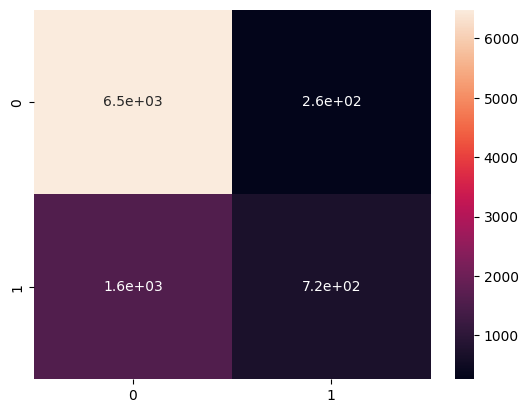

In [ ]:
best_model =grid_result.best_estimator_
X_test = X_test.astype(int)
# Predicting the Test set results
y_pred = best_model.predict(X_test)
print(y_pred)
y_pred = (y_pred > 0.5)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

Create the model for k-fold validation to obtain Training and Validation accuracies using the best hyperparameters.

In [ ]:
model = create_model(20, 'RMSprop')
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 20)                300       
                                                                 
 dense_58 (Dense)            (None, 10)                210       
                                                                 
 dropout_19 (Dropout)        (None, 10)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
 activation_19 (Activation)  (None, 1)                 0         
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


K-fold vaidation and plotting the graphs

Training for fold 1 ...
Epoch 1/20
227/227 [==============================] - 8s 6ms/step - loss: 0.4855 - accuracy: 0.7694 - val_loss: 0.3831 - val_accuracy: 0.8278
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3944 - accuracy: 0.8145 - val_loss: 0.3454 - val_accuracy: 0.8419
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3713 - accuracy: 0.8244 - val_loss: 0.3333 - val_accuracy: 0.8480
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3617 - accuracy: 0.8282 - val_loss: 0.3251 - val_accuracy: 0.8507
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8311 - val_loss: 0.3222 - val_accuracy: 0.8530
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3515 - accuracy: 0.8337 - val_loss: 0.3205 - val_accuracy: 0.8520
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3497 - accuracy: 0.8358 - val_loss: 0.3178 - val

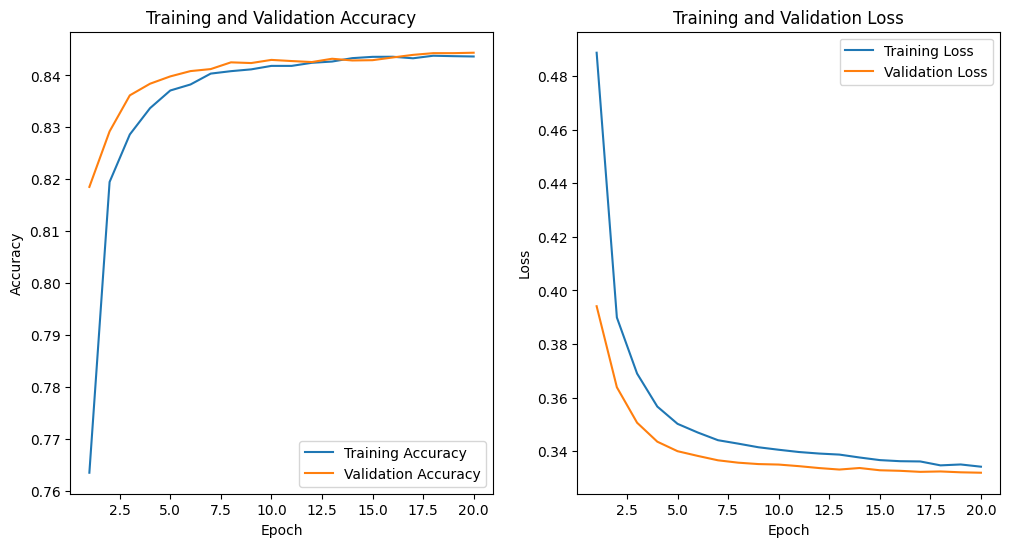

In [ ]:
# K-fold Cross Validation model evaluation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold = []
loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []

fold_no = 1
for train, val in kfold.split(X_train, y_train):
    # Create a new instance of the model
    model = create_model(20, 'RMSprop')
    print(f'Training for fold {fold_no} ...')
    X_training = X_train
    # Fit data to model
    history = model.fit(X_training[train], y_train[train],
                        batch_size=128,
                        epochs=20,
                        verbose=1,
                        validation_data=(X_training[val], y_train[val]))

    # Append history
    acc_per_fold.append(history.history['accuracy'])
    loss_per_fold.append(history.history['loss'])
    val_acc_per_fold.append(history.history['val_accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])

    print(f'Completed fold {fold_no}')
    fold_no += 1

# Calculate average and standard deviation across folds
mean_acc = np.mean(acc_per_fold, axis=0)
mean_loss = np.mean(loss_per_fold, axis=0)
mean_val_acc = np.mean(val_acc_per_fold, axis=0)
mean_val_loss = np.mean(val_loss_per_fold, axis=0)

epochs_range = range(1, 21) # Adjust based on your epochs

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mean_acc, label='Training Accuracy')
plt.plot(epochs_range, mean_val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, mean_loss, label='Training Loss')
plt.plot(epochs_range, mean_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Save the figures
plt.savefig('training_validation_accuracy_loss.png')

plt.show()

Confusion matrix for the trained model.

283/283 [==============================] - 1s 2ms/step
[[6306  439]
 [ 955 1345]]
0.8458817025981205


<Axes: >

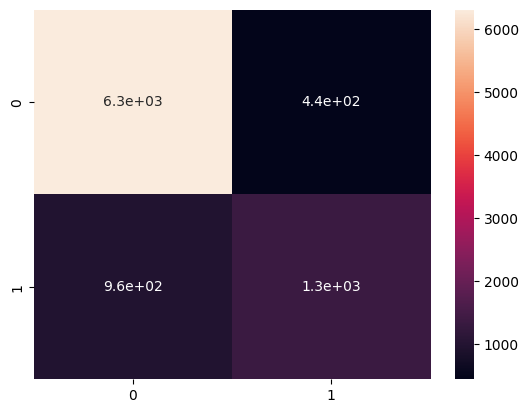

In [ ]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
sns.heatmap(cm, annot=True)